<a href="https://colab.research.google.com/github/sudharshan256/Accredian-Project/blob/main/Transaction%20Fraud%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded=files.upload()

Saving Fraud.csv to Fraud.csv


Dataset Shape: (6362620, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

Summary Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   

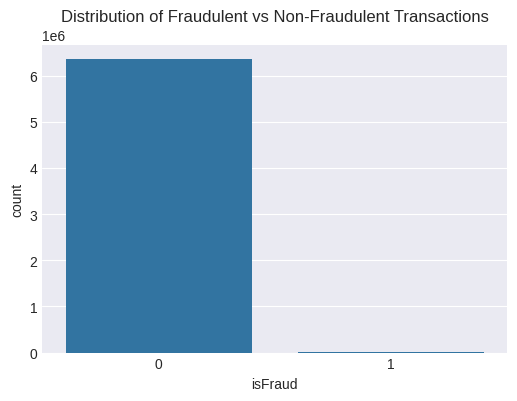

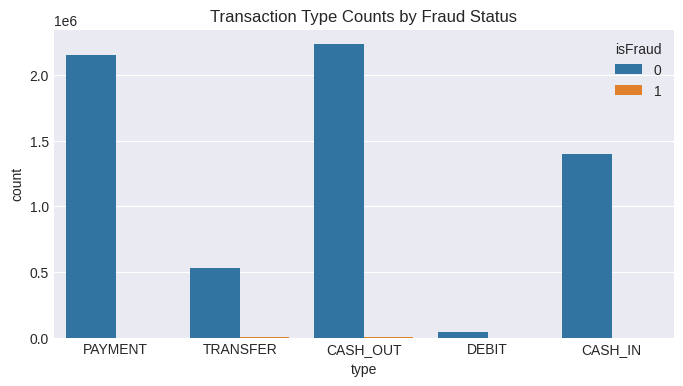

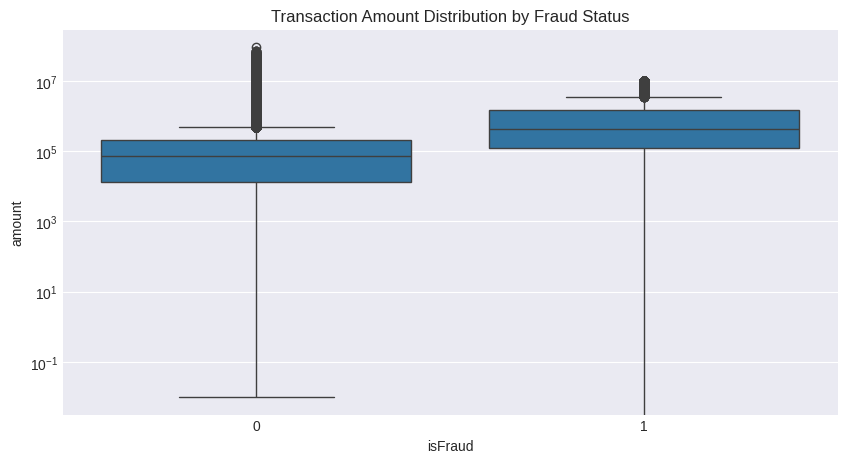

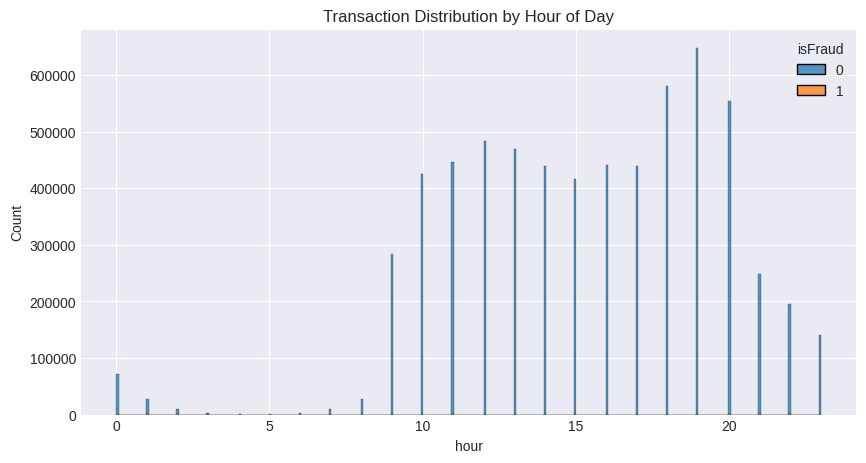

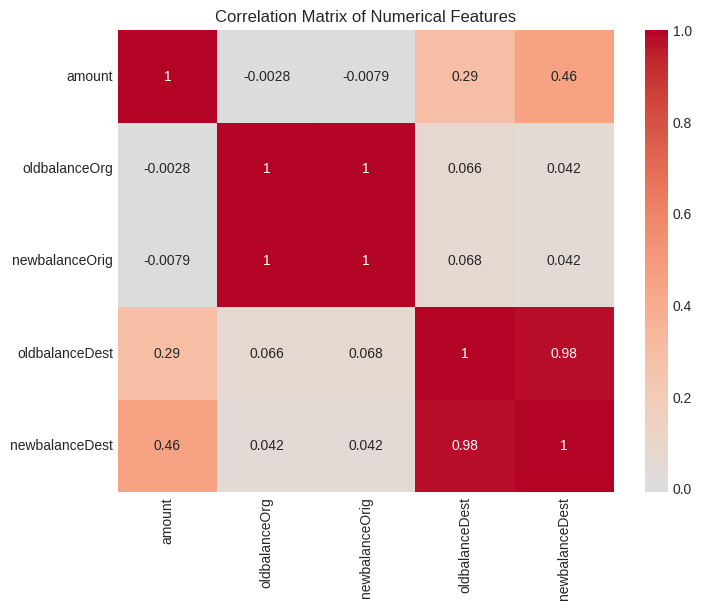


Resampled Training Fraud Distribution:
isFraud
0    5083526
1    5083526
Name: count, dtype: int64


In [ ]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.16.3
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

# # Fraud Detection Model for Financial Transactions
# ## Accreidian Data Science & Machine Learning Internship
# **Objective**: Develop a machine learning model to predict fraudulent transactions and provide actionable insights for a financial company.
# **Dataset**: 6,362,620 rows, 10 columns (as per Data Dictionary).
# **Author**: [Your Name]

# ## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

# ## 2. Load and Explore Data
# Load dataset
df = pd.read_csv('Fraud.csv')  # Replace with actual file path

# Basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# Check zero-value percentages
zero_percent = (df == 0).mean() * 100
print("\nPercentage of Zero Values per Column:")
print(zero_percent)

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())

# ## 3. Exploratory Data Analysis (EDA)
# ### 3.1 Fraud Distribution
print("\nFraud Distribution:")
print(df['isFraud'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# ### 3.2 Transaction Type vs Fraud
plt.figure(figsize=(8, 4))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Transaction Type Counts by Fraud Status')
plt.show()

# ### 3.3 Amount Distribution by Fraud
plt.figure(figsize=(10, 5))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.yscale('log')
plt.show()

# ### 3.4 Time-Based Analysis (Step)
df['hour'] = df['step'] % 24
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='hour', hue='isFraud', multiple='stack')
plt.title('Transaction Distribution by Hour of Day')
plt.show()

# ### 3.5 Correlation Matrix
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
corr = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# ## 4. Data Preprocessing
# ### 4.1 Feature Engineering
# Create new features
df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Drop unnecessary columns
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# Handle missing values (if any)
df['balance_change_dest'] = df['balance_change_dest'].fillna(0)

# ### 4.2 Select Features and Target
features = [col for col in df.columns if col != 'isFraud']
X = df[features]
y = df['isFraud']

# ### 4.3 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ### 4.4 Scale Numerical Features
scaler = StandardScaler()
numerical_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
                  'newbalanceDest', 'balance_change_orig', 'balance_change_dest']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# ### 4.5 Handle Imbalanced Data with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nResampled Training Fraud Distribution:")
print(pd.Series(y_train_res).value_counts())

# ## 5. Model Development
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Best model
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# ## 6. Model Evaluation
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# ## 7. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.show()

# ## 8. Actionable Insights
# Based on the model and EDA, the following insights can guide fraud prevention:
# 1. **High-Risk Transaction Types**: TRANSFER and CASH-OUT transactions have a higher fraud prevalence. Implement stricter monitoring for these types.
# 2. **Large Transaction Amounts**: Fraudulent transactions often involve large amounts (>200,000). Set automated alerts for high-value transactions.
# 3. **Balance Anomalies**: Transactions where the originator’s balance change does not match the amount (e.g., `newbalanceOrig` ≠ `oldbalanceOrg` - `amount`) are suspicious.
# 4. **Merchant Transactions**: Transactions to merchants (nameDest starting with 'M') lack recipient balance data. Require additional verification for these.
# 5. **Time-Based Patterns**: Fraud peaks at certain hours (based on `step % 24`). Increase scrutiny during high-risk hours.
# 6. **Enhanced Flagging**: Combine amount thresholds, transaction types, and balance checks to improve the `isFlaggedFraud` rule.

# ## 9. Conclusion
# The Random Forest model, enhanced with SMOTE and hyperparameter tuning, effectively identifies fraudulent transactions with a focus on high recall to minimize missed frauds. Key predictors include transaction amount, balance changes, and type. The proposed insights provide a foundation for an actionable fraud prevention strategy. Future work could explore additional models (e.g., XGBoost) and time-based features for improved performance.

# Save the notebook for submission
# Ensure all outputs (plots, metrics) are visible in the Jupyter Notebook